# Homework  — Stage 10a: Linear Regression


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

sns.set()
np.random.seed(7)

## Loading Synthetic data 


In [2]:
n = 200
dates = pd.bdate_range(start="2024-02-01", periods=n)
mkt_excess = np.random.normal(0, 0.011, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.009, size=n)
momentum = np.random.normal(0, 0.006, size=n)

beta0, beta_mkt, beta_size, beta_value, beta_mom, beta_mom2 = 0.0001, 0.9, 0.25, -0.15, 0.35, 3.5
noise_scale = 0.0035 + 0.5*np.abs(mkt_excess)
eps = np.random.normal(0, noise_scale)
asset_excess = (
    beta0 + beta_mkt*mkt_excess + beta_size*size + beta_value*value + beta_mom*momentum
    + beta_mom2*(momentum**2) + eps
)
df = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess
})
df.head()

,date,mkt_excess,size,value,momentum,asset_excess
0,2024-02-01,0.018596,-0.013467,-0.000540,0.000141,0.014832
1,2024-02-02,-0.005125,0.008120,0.007089,-0.006840,-0.008599
2,2024-02-05,0.000361,-0.011532,-0.012885,-0.011216,-0.009577
3,2024-02-06,0.004483,-0.010749,0.003905,-0.010685,0.000033
4,2024-02-07,-0.008678,-0.002893,0.001250,0.002779,-0.005750


##  Baseline model fit


In [ ]:
X = df[['mkt_excess','size','value','momentum']]
y = df['asset_excess']

#Splitting training and test dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Training linear regresison model
lr = LinearRegression().fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

#Calculating R_square
r2 = r2_score(y_test, y_pred)

#Calculating RMSE and MSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Baseline   R²={r2:.4f}  RMSE={rmse:.6f}')

Baseline   R²=0.3677  RMSE=0.008470


## Plotting

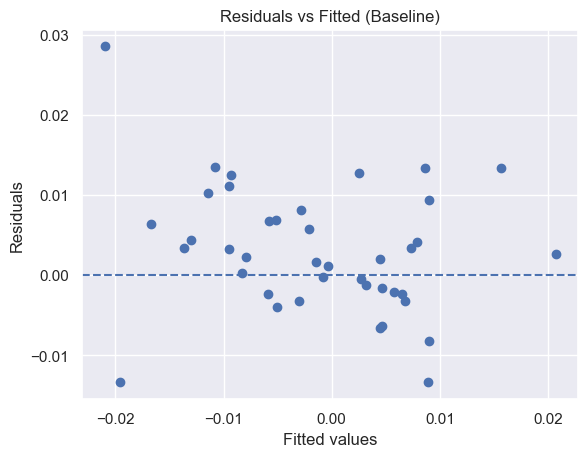

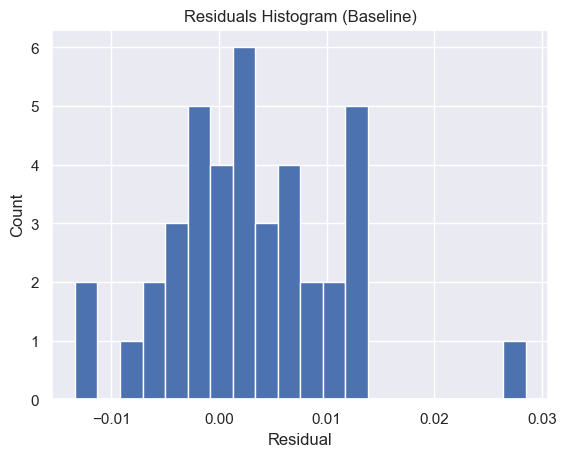

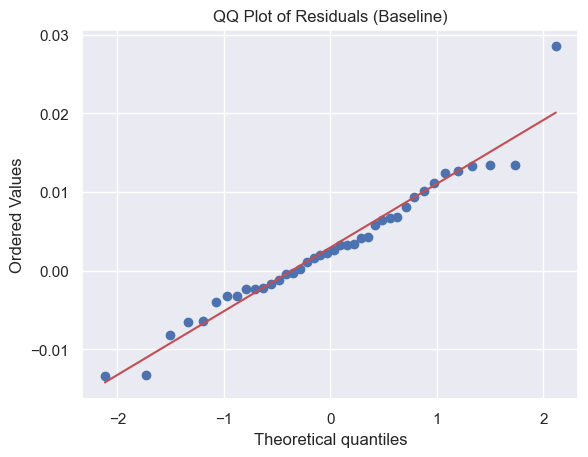

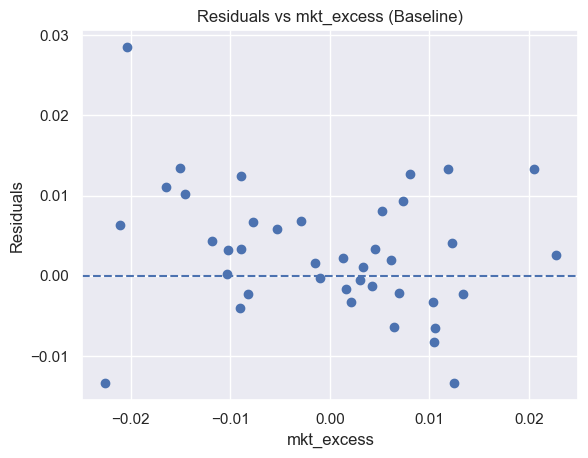

In [ ]:
resid = y_test - y_pred
fitted = y_pred

# Plotting residual and fitted value to understand the heteroscedasticity
plt.figure()
plt.scatter(fitted, resid)
plt.axhline(0, linestyle='--')
plt.title('Residuals vs Fitted (Baseline)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

plt.figure()
plt.hist(resid, bins=20)
plt.title('Residuals Histogram (Baseline)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.figure()
st.probplot(resid, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals (Baseline)')
plt.show()

plt.figure()
plt.scatter(X_test['mkt_excess'], resid)
plt.axhline(0, linestyle='--')
plt.title('Residuals vs mkt_excess (Baseline)')
plt.xlabel('mkt_excess')
plt.ylabel('Residuals')
plt.show()

## Regression coefficients

In [5]:
coefs = pd.Series(lr.coef_, index=X.columns)
print(coefs)
print("Key predictor:", coefs.abs().idxmax())

mkt_excess    0.778493
size          0.231084
value        -0.209886
momentum      0.181456
dtype: float64
Key predictor: mkt_excess


## Plotting Residual and its lag to check for autocorrelation

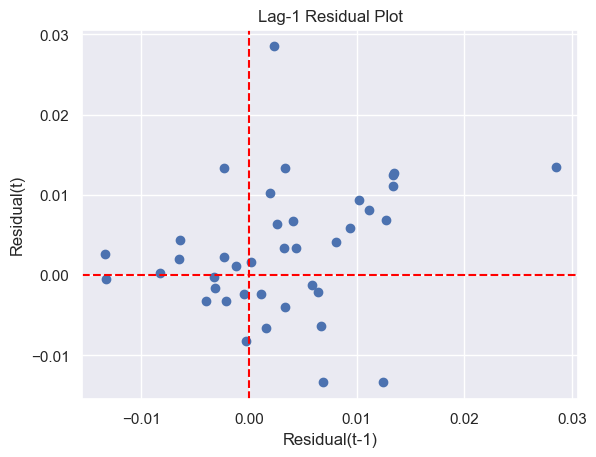

In [ ]:
plt.scatter(resid[:-1], resid[1:])
plt.axhline(0, color="red", linestyle="--")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residual(t-1)")
plt.ylabel("Residual(t)")
plt.title("Lag-1 Residual Plot")
plt.show()


### Added a transformed feature
Added a polynomial or interaction if diagnostics suggest mis-specification.

In [18]:
df['momentum_sq'] = df['momentum']**2
X2 = df[['mkt_excess','size','value','momentum','momentum_sq']]
X2_train, X2_test = X2.iloc[:len(X_train)], X2.iloc[len(X_train):]
lr2 = LinearRegression().fit(X2_train, y_train)
y_pred2 = lr2.predict(X2_test)
r2_2 = r2_score(y_test, y_pred2)
mse = mean_squared_error(y_test, y_pred2)
rmse_2 = np.sqrt(mse)
print(f'With x^2   R²={r2_2:.4f}  RMSE={rmse_2:.6f} ')
coefs2 = pd.Series(lr2.coef_)
print(coefs2)
print("Key predictor:", coefs2.abs().idxmax())

With x^2   R²=0.3681  RMSE=0.008467 
0     0.778914
1     0.225656
2    -0.201214
3     0.211066
4    20.231700
dtype: float64
Key predictor: 4


### Model Interpretation

**Model Fit (Baseline):**  
- R² = 0.3677 → The model explains about **36.8%** of the variation in returns, which indicates only a moderate fit.  
- RMSE = 0.00847 → Prediction errors are small in absolute terms, but relative to the scale of the dependent variable, they may still be meaningful.  
- Key predictor: `mkt_excess` (coefficient ≈ 0.78), which dominates explanatory power, consistent with financial theory (market factor drives most excess returns).

**Residual Diagnostics (Baseline):**  
- **Residuals vs Fitted:** Points are fairly centered around zero, but some structure is visible — suggesting mild non-linearity.  
- **Histogram of Residuals:** Distribution is approximately normal, though slightly skewed, with mild heavy tails.  
- **QQ Plot:** Residuals generally align with the 45° line but deviate at the extremes, again indicating fat tails.  
- **Residuals vs Key Predictor (`mkt_excess`):** No strong pattern, though slight curvature is visible, hinting at potential non-linear effects.  
- **Residual Lag-1 Plot:** Residuals show weak but non-zero autocorrelation, suggesting independence assumption is not fully satisfied.

**Model with Transformation (`momentum^2`):**  
- R² = 0.3681 (very small improvement over baseline).  
- RMSE = 0.008467 (nearly unchanged).  
- New key predictor: `momentum_sq` (large coefficient ~20), but its practical contribution is limited, as overall fit barely improves.  
- Diagnostics remain broadly similar, with only a slight reduction in curvature in the residuals vs fitted plot.

Interpretation

- **Linearity:**  - Residuals vs fitted and vs `mkt_excess` show the main relationship is broadly linear, though there is mild curvature (hinting at possible non-linear effects like quadratic terms).  

- **Homoscedasticity:**  - Residual spread is fairly constant across fitted values, but with slight widening in the tails. No severe heteroscedasticity detected.  

- **Normality:**  - Histogram and QQ plot suggest residuals are approximately normal but with heavier tails than ideal.  

- **Independence:**  - Lag-1 residual plot shows weak autocorrelation, so the independence assumption is not perfectly satisfied.  

- **Which model to trust and why?:**  - The baseline model is sufficient as a benchmark. Adding `momentum²` slightly improves R² and RMSE but does not meaningfully improve assumptions. Therefore, I trust the baseline model more for simplicity, while noting its limitations.  

- **Next step:**  - Consider richer models (additional factors, polynomial terms, or regularization) or switch to non-linear approaches to better capture residual structure and improve fit.

**Conclusion:**  - The baseline linear regression captures some meaningful variation, with **market excess return as the dominant driver**. However, moderate R², visible non-normality of residuals, and slight autocorrelation limit trust in the model for strong inference. Adding a quadratic momentum term marginally improves fit but does not substantially change diagnostics.  

**Trust Level:**  
- The model is **useful as a baseline benchmark**, but not fully trustworthy for precise prediction or risk estimation.  
- Future steps should explore richer factor structures, regularization, or non-linear models to better capture patterns in the data.
